<a href="https://colab.research.google.com/github/jo-cho/advanced_in_financial_machine_learning/blob/master/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 Exercise

In [0]:
import numpy as np
import pandas as pd
!pip install -q mlfinlab
import mlfinlab
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 122kB 2.9MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from mlfinlab import data_structures, features, filters, labeling

## 4.1.

## (a)

In [0]:
#달러 바 만들기
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
#threshold = 1백만

#df 다듬기
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars.head()

Reading data in batches:
Batch number: 0
Returning bars 



,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:46:35,50.79,51.07,50.710,51.07,19844
2009-09-28 09:53:49,51.07,51.15,51.050,51.14,20324
2009-09-28 09:55:26,51.14,51.15,51.129,51.14,19622
2009-09-28 10:02:52,51.14,51.26,51.080,51.25,22319
2009-09-28 10:10:21,51.25,51.29,51.190,51.29,21519


In [0]:
len(dollar_bars)

59578

In [0]:
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')
dollar_bars.head()
len(dollar_bars)

58607

In [0]:
close = dollar_bars.close

In [0]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [0]:
DailyVol = getDailyVol(close=dollar_bars.close)
DailyVol = DailyVol.dropna()
h = DailyVol.mean()

In [0]:
tEvents = filters.cusum_filter(close,h)

In [0]:
t1 = labeling.add_vertical_barrier(tEvents,close,num_days=1)

In [0]:
t1

2009-09-28 12:33:18   2009-09-29 12:34:54
2009-09-29 09:27:39   2009-09-30 09:32:03
2009-09-29 12:00:17   2009-09-30 12:48:14
2009-09-30 09:44:47   2009-10-01 09:52:26
2009-09-30 09:56:31   2009-10-01 10:00:15
                              ...        
2019-06-18 09:39:43   2019-06-19 09:57:29
2019-06-20 09:30:00   2019-06-21 09:30:00
2019-06-20 12:20:48   2019-06-21 12:28:50
2019-06-20 15:50:44   2019-06-21 15:59:41
2019-06-25 09:42:50   2019-06-26 09:54:29
Name: date_time, Length: 3164, dtype: datetime64[ns]

### (b)

In [0]:
from mlfinlab import sample_weights, sampling

In [0]:
molecule = np.array(close.index[0:1000]) #잘 모르겠음

In [0]:
c = sampling.num_concurrent_events(close.index,t1,molecule)

In [0]:
c

date_time
2009-09-28 12:33:18    1
2009-09-28 13:20:29    1
2009-09-28 13:44:27    1
2009-09-28 14:05:46    1
2009-09-28 14:11:43    1
                      ..
2010-01-19 15:08:50    1
2010-01-19 15:34:01    1
2010-01-20 09:32:42    1
2010-01-20 09:57:21    1
2010-01-20 10:54:08    2
Length: 991, dtype: int64

### (c)

In [0]:

coEvents_std = (pd.DataFrame().assign(numCoEvents = c, std = close.pct_change().dropna().ewm(50).std()))

In [0]:
coEvents_std

,numCoEvents,std
date_time,,
2009-09-28 12:33:18,1,0.000854
2009-09-28 13:20:29,1,0.000821
2009-09-28 13:44:27,1,0.000847
2009-09-28 14:05:46,1,0.000975
2009-09-28 14:11:43,1,0.001049
...,...,...
2010-01-19 15:08:50,1,0.002140
2010-01-19 15:34:01,1,0.002138
2010-01-20 09:32:42,1,0.002358


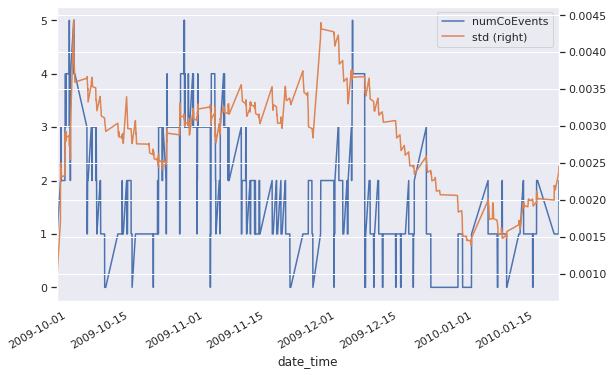

In [0]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)

### (d)

In [0]:
import plotnine as pn

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:

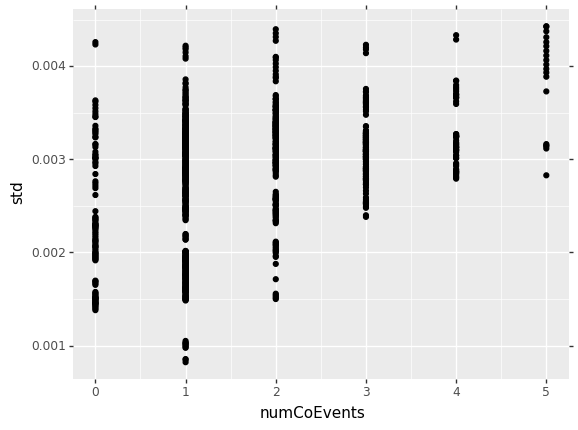

<ggplot: (8785611794952)>

In [0]:
(pn.ggplot(coEvents_std, pn.aes('numCoEvents', 'std'))
 +pn.geom_point()
 +pn.stat_smooth())

In [0]:
#overlap이 많이 됐을 때 수익률 분산이 큼


# 4.2.

In [0]:
pt_sl=[1,1]
target = DailyVol

In [0]:
tripple_barrier_events = labeling.get_events(close, tEvents,pt_sl,target,min_ret=0.01,num_threads=1,vertical_barrier_times=False,side_prediction= None)

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [0]:
tW = sampling.get_av_uniqueness_from_triple_barrier(tripple_barrier_events,close,1)

In [0]:
tW

,tW
2009-10-02 09:32:42,0.812500
2009-10-02 10:34:31,0.920000
2009-10-05 12:55:39,0.900000
2009-10-06 09:31:29,0.344048
2009-10-06 11:16:28,0.311538
...,...
2019-05-15 09:30:00,0.269271
2019-05-15 10:38:24,0.262644
2019-05-16 10:01:27,0.454610
2019-05-17 09:30:00,0.333333


In [0]:
from statsmodels.tsa.ar_model import AR, ARResults

In [0]:
ar = AR(tW)
modelar = ar.fit(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
modelar.params

const    0.094741
L1.tW    0.724575
dtype: float64

In [0]:
print(modelar.pvalues,2*'\n', modelar.tvalues)
#yes

const     1.213312e-27
L1.tW    8.382844e-261
dtype: float64 

 const    10.895326
L1.tW    34.498724
dtype: float64


# 4.3

## (a)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Xy = (pd.DataFrame().assign(close=close,close_lag=close.shift(1))).dropna()
## i'm not sure what this is. 

y = Xy.loc[:,'close'].values
X = Xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,shuffle=False)

n_estimator = 50
rf = RandomForestRegressor(max_depth=2, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           )
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [0]:
rf.oob_score_

0.9299113276282317

## (b)